## 009 Prototype model classes (single subject)

Date: 25.Jul.2022

### Purpose

Create a Prototype abstract class that specific models can inherit from.

### Outline of Plan

1. Model-agnostic initialization
2. Model-agnostic aesara scan code
3. Model-agnostic loading for actions, rewards, craving, normalized craving
4. Model-agnostic generation and execution of MCMC sampling
5. Model-specific initialization
6. Model-specific update function
7. Model-specific prior specification and fitting

### What we did in this notebook

1. Implemented normed modeling prototype class
2. Assumptions:
   1. Only one beta term, and it is ALWAYS the first variable unpacked in the model fitting
   2. Self-reported cravings are normed
   3. Sigma for the normal distribution that normed cravings are drawn from is equals 1. Increasing this to 10 leads to extremely poor model estimation.
3. Plotted predicted vs true normed craving ratings (fit does not look great unfortunately).
4. For single subject model comparison, spot checked for subjects #7 and #8, WAIC does not reveal big difference between EV and EVRPE
5. Things to try now:
   1. Non-normed version of prediction model, might fit to real data better
   2. Think about how to incorporate models that look one or two steps back for Qs and RPEs

In [10]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara
from scipy import stats

from abc import ABC, abstractmethod

from sys import path
import os

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [12]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.4) & 
    (df_summary['Other Accuracy']>0.4)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
longform

,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## Passive joint model classes

In [6]:
class Explicit_Passive_Norm_RW_EVRPE:
    def __init__(self, longform, summary, project_dir):
        self.name = 'Passive_RW_EVRPE'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

    def update_Q(self, a, r, Qs, al, beta_0, beta_1, beta_2):
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (pe))
        Qs = at.set_subtensor(Qs[-1], beta_0 + beta_1 * Qs[a] + beta_2 * pe) 
        return Qs

    def right_action_probs(self, sample_alpha, sample_beta, sample_b0, sample_b1, sample_b2, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
        t_Qs_crav, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs_crav],
            non_sequences=[sample_alpha, sample_b0, sample_b1, sample_b2])
        t_Qs = t_Qs_crav[:, :2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]),  t_Qs_crav[:, 2]

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        craving_inds = np.squeeze(np.argwhere(cravings>-1))
        mask = np.ones(len(craving_inds), dtype=bool)
        mask[12] = False
        craving_inds = craving_inds[mask]
        cravings = cravings[craving_inds]
        self.mean_craving = np.mean(cravings)
        self.std_craving = np.std(cravings)
        self.norm_cravings = stats.zscore(cravings)
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
            weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
            weight_one = pm.Normal('weight_one', mu=0, sigma=1)
            weight_two = pm.Normal('weight_two', mu=0, sigma=1)
            action_probs, craving_pred = self.right_action_probs(alpha, beta, weight_zero, weight_one, weight_two, act, rew)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[craving_inds-1], sigma=10, observed=self.norm_cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

## Prototype class testing

In [3]:
def test(x, *args):
    print([x, *args])
    print(args[0])

test(1, 2, 3)

[1, 2, 3]
2


In [114]:
class NormPrototype(ABC):
    def __init__(self, longform, summary, project_dir):
        self.name = None        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        num_trials = 20
        num_blocks = 2
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_trials))
        self._calc_norm_cravings()
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)

    @abstractmethod
    def update_Q(self, a, r, Qs, *args):
        pass

    def right_action_probs(self, actions, rewards, *args):
        # Note that the first arg in args is always the sample_beta
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')
        beta = args[0]

        # Compute the Qs values
        t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
        t_Qs_crav, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs_crav],
            non_sequences=[*args])
        t_Qs = t_Qs_crav[:, :2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]),  t_Qs_crav[:, 2]
    
    def _load_act_rew_craving(self, pid, block):
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        craving_inds = np.squeeze(np.argwhere(cravings>-1))
        mask = np.ones(len(craving_inds), dtype=bool)
        mask[12] = False
        craving_inds = craving_inds[mask]
        cravings = cravings[craving_inds]
        norm_cravings = stats.zscore(cravings)
        return act, rew, craving_inds, norm_cravings
    
    @abstractmethod
    def _define_priors(self):
        # Beta must be returned first!
        pass

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act, rew, craving_inds, norm_cravings = self._load_act_rew_craving(pid, block)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[craving_inds-1], sigma=1, observed=norm_cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

In [108]:
class Passive_Norm_RW_EVRPE(NormPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Passive_Norm_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        beta, alpha, w0, w1, w2 = args
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))
        Qs = at.set_subtensor(Qs[-1], w0 + w1 * Qs[a] + w2 * pe) 
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two

In [44]:
class Explicit_Passive_Norm_RW_EV:
    def __init__(self, longform, summary, project_dir):
        self.name = 'Passive_RW_EV'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

    def update_Q(self, a, r, Qs, al, beta_0, beta_1):
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (pe))
        Qs = at.set_subtensor(Qs[-1], beta_0 + beta_1 * Qs[a]) 
        return Qs

    def right_action_probs(self, sample_alpha, sample_beta, sample_b0, sample_b1, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
        t_Qs_crav, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs_crav],
            non_sequences=[sample_alpha, sample_b0, sample_b1])
        t_Qs = t_Qs_crav[:, :2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]),  t_Qs_crav[:, 2]

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        craving_inds = np.squeeze(np.argwhere(cravings>-1))
        mask = np.ones(len(craving_inds), dtype=bool)
        mask[12] = False
        craving_inds = craving_inds[mask]
        cravings = cravings[craving_inds]
        self.mean_craving = np.mean(cravings)
        self.std_craving = np.std(cravings)
        self.norm_cravings = stats.zscore(cravings)
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
            weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
            weight_one = pm.Normal('weight_one', mu=0, sigma=1)
            action_probs, craving_pred = self.right_action_probs(alpha, beta, weight_zero, weight_one, act, rew)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[craving_inds-1], sigma=1, observed=self.norm_cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

In [45]:
class Passive_Norm_RW_EV(NormPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Passive_Norm_RW_EV'
    
    def update_Q(self, a, r, Qs, *args):
        beta, alpha, w0, w1 = args
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))
        Qs = at.set_subtensor(Qs[-1], w0 + w1 * Qs[a]) 
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one

In [109]:
test_model = Passive_Norm_RW_EVRPE(longform, df_summary, project_dir)
# test_model.fit(8, 'other')

In [113]:
test_model.norm_cravings[1, 8, :]

array([-0.1877293 ,  0.75091721,  1.22024046,  1.22024046,  0.28159395,
       -0.1877293 ,  0.28159395,  0.75091721,  0.28159395,  0.28159395,
       -0.1877293 , -0.1877293 , -3.00366883,  0.28159395,  0.28159395,
       -0.65705256, -0.65705256, -1.12637581, -1.12637581,  1.68956372])

In [15]:
test_model2 = Explicit_Passive_Norm_RW_EVRPE(longform, df_summary, project_dir)
test_model2.fit(8, 'other')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [untr_alpha]
>Metropolis: [beta]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


In [84]:
test_model3 = Passive_Norm_RW_EV(longform, df_summary, project_dir)
test_model3.fit(8, 'other')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


In [86]:
test_model4 = Explicit_Passive_Norm_RW_EV(longform, df_summary, project_dir)
test_model4.fit(8, 'other')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [untr_alpha]
>Metropolis: [beta]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


In [85]:
test_model.traces['other']

{'57c9c13079ad9b0001e416be': Inference data with groups:
 	> posterior
 	> posterior_predictive
 	> log_likelihood
 	> sample_stats
 	> prior
 	> prior_predictive
 	> observed_data}

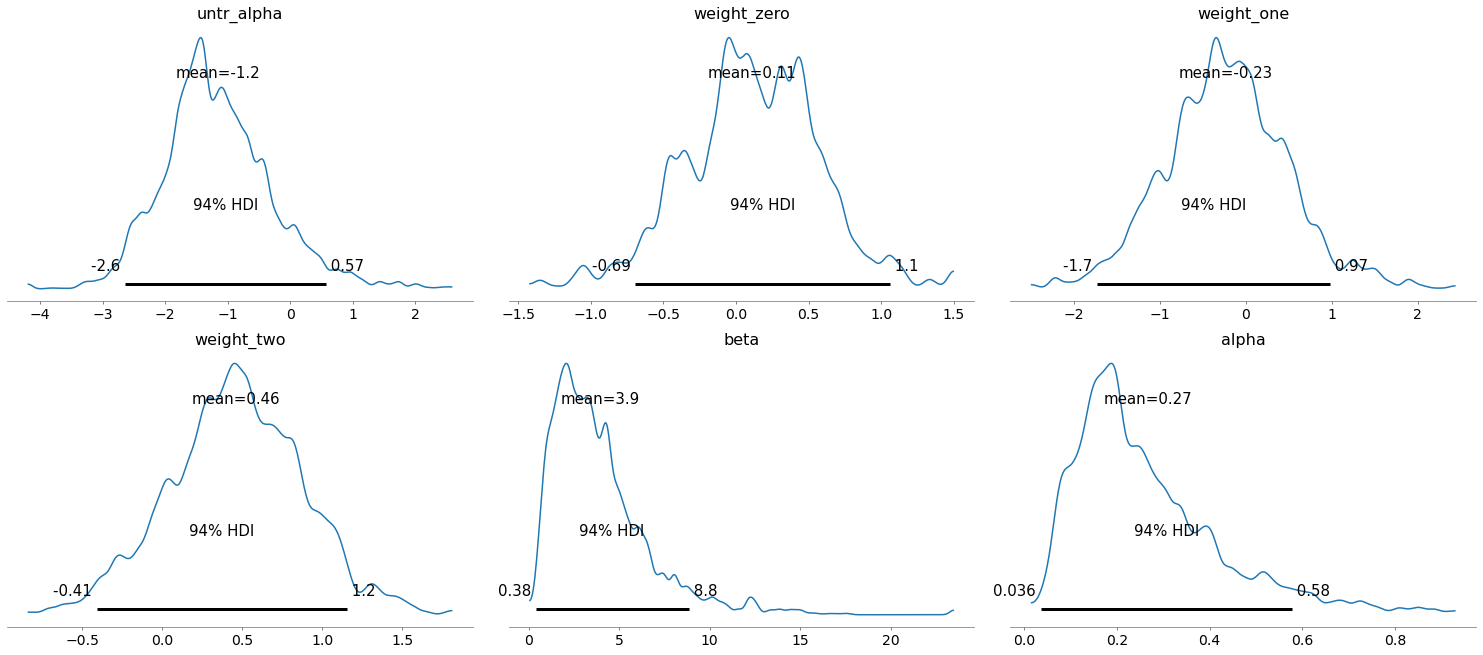

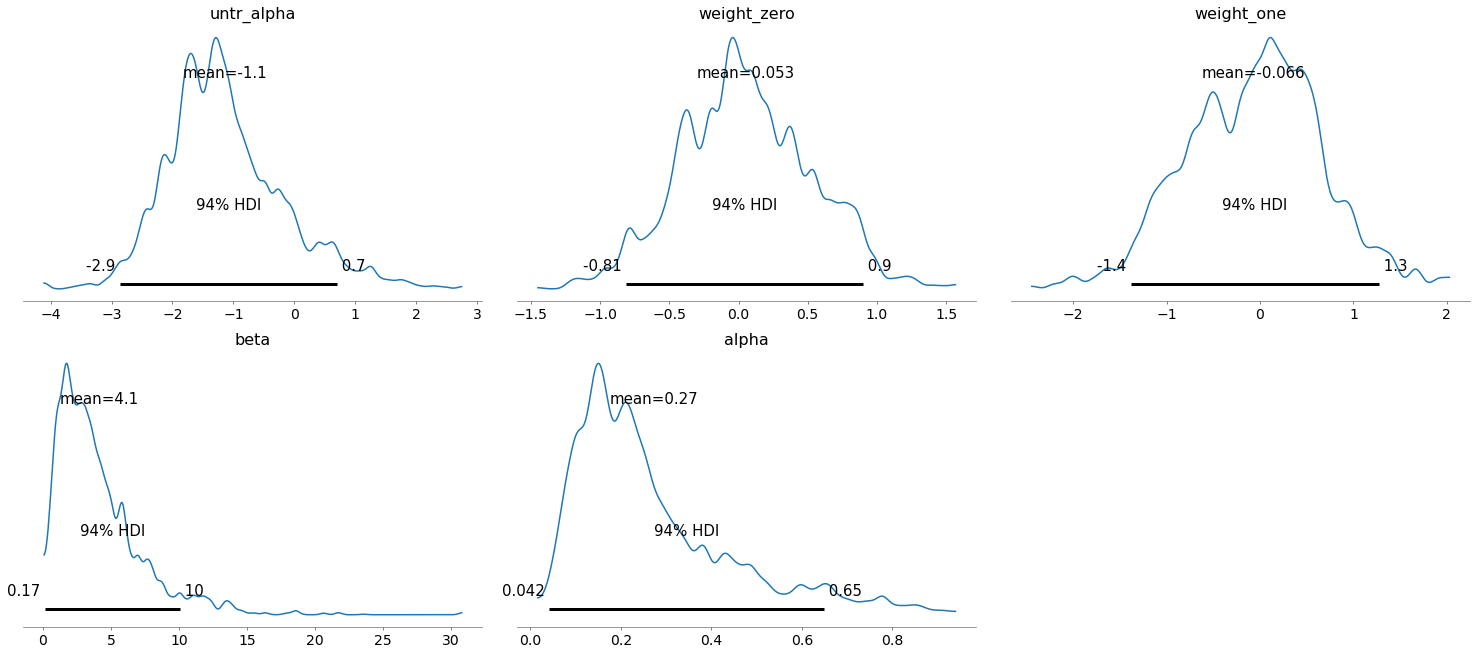

In [87]:
az.plot_posterior(test_model.traces['other']['57c9c13079ad9b0001e416be'])
plt.tight_layout()
az.plot_posterior(test_model3.traces['other']['57c9c13079ad9b0001e416be'])
plt.tight_layout()


<AxesSubplot:>

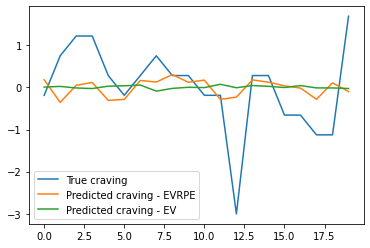

In [88]:
sns.lineplot(
    x=np.arange(len(test_model4.norm_cravings)),
    y=test_model4.norm_cravings,
    label='True craving'
)
sns.lineplot(
    x=np.arange(len(test_model4.norm_cravings)),
    y=test_model.traces['other']['57c9c13079ad9b0001e416be'].posterior_predictive.craving_like.values[0].mean(axis=0),
    label='Predicted craving - EVRPE'
)
sns.lineplot(
    x=np.arange(len(test_model4.norm_cravings)),
    y=test_model3.traces['other']['57c9c13079ad9b0001e416be'].posterior_predictive.craving_like.values[1].mean(axis=0),
    label='Predicted craving - EV'
)


## Model comparison of EV and EVRPE

<AxesSubplot:xlabel='Log'>

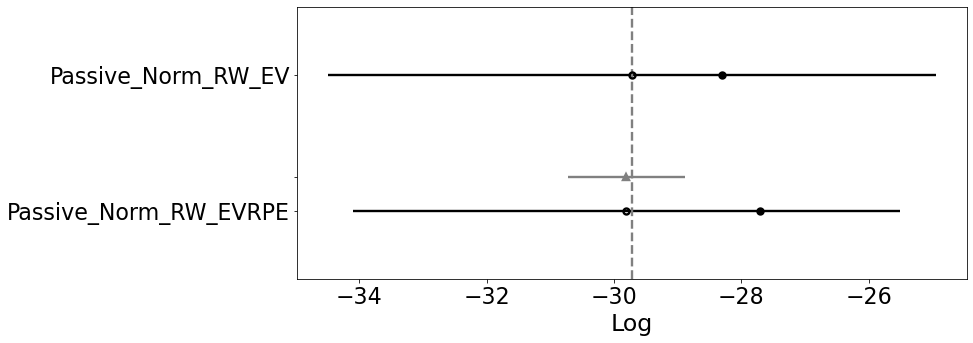

In [89]:
az.plot_compare(az.compare({
        'Passive_Norm_RW_EV': test_model3.traces['other']['57c9c13079ad9b0001e416be'],
        'Passive_Norm_RW_EVRPE': test_model.traces['other']['57c9c13079ad9b0001e416be'],
    },
    ic='loo',
    var_name='craving_like'
),insample_dev=True, figsize=(12,5))